In [1]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Load data

In [5]:
data = pd.read_csv("../test.csv", index_col=0)
train = data.loc[:1000,:]
test = data.loc[1001:,:]

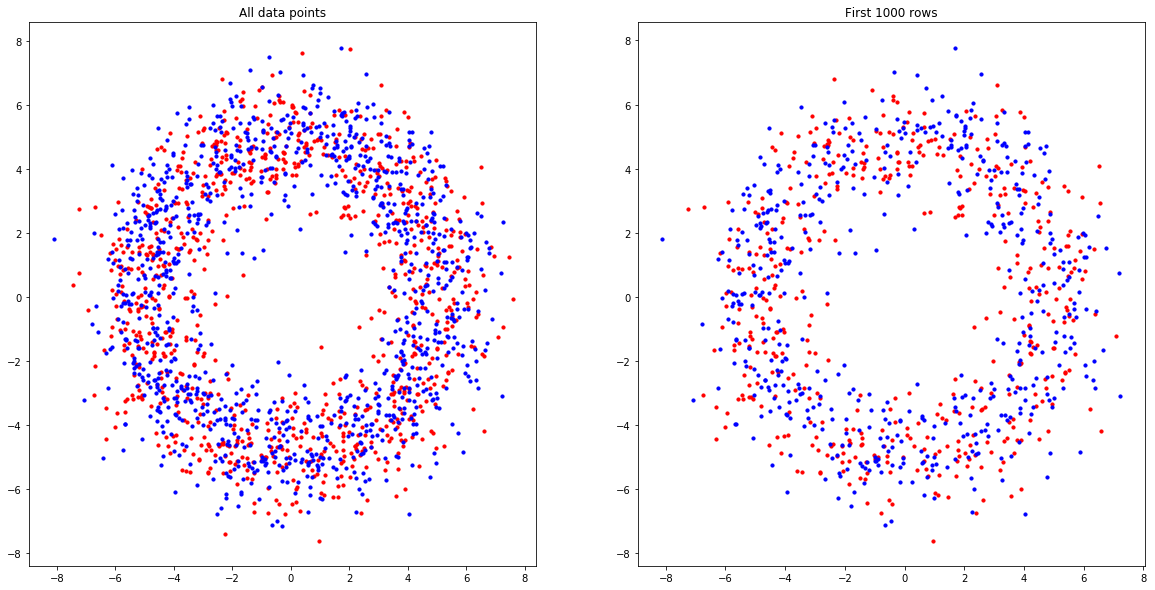

In [7]:
plt.figure(figsize = (20,10))

plt.subplot(121, title='All data points')
plt.scatter(data.loc[data['label']==1,'x1'], data.loc[data['label']==1,'x2'], c='r', s=10)
plt.scatter(data.loc[data['label']==0,'x1'], data.loc[data['label']==0,'x2'], c='b', s=10)

plt.subplot(122, title='First 1000 rows')
train = data.loc[:1000, :]
plt.scatter(train.loc[train['label']==1,'x1'], train.loc[train['label']==1,'x2'], c='r', s=10)
plt.scatter(train.loc[train['label']==0,'x1'], train.loc[train['label']==0,'x2'], c='b', s=10)

Save the dataset so we can reuse it later

# Models

In [8]:
online_model = MLPClassifier((64, 32, ), learning_rate='adaptive', batch_size=1)
offline_model = MLPClassifier((64, 32, ), learning_rate='adaptive', solver='sgd')

In [9]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import PolynomialFeatures
transformer = RBFSampler(n_components=100, gamma=0.075)
# transformer = PolynomialFeatures(degree=5)
gridt = transformer.fit_transform(grid)

NameError: name 'grid' is not defined

In [10]:
j = 0
acc_online = []
acc_offline = []
for n, row in enumerate(test.values):
    datapoint = np.array([row[:-1]])
    label = row[-1].reshape(-1)
    # --- Update online
    online_model.partial_fit(datapoint, label, classes=[0,1])
#     input()
    
    # --- Add to queue for offline
    offline_points = np.append(offline_points, [row], 0)
    j+=1
    if j > 100:
        j = 0
        offline_model.fit(offline_points[:,:-1], offline_points[:,-1])
    
    # --- Predict new point
    pred_online = online_model.predict(datapoint)
    pred_offline = offline_model.predict(datapoint)

    acc_online.append(np.random.random(1)*100)
    acc_offline.append(np.random.random(1)*100)

    # --- Plot
    if n % 10 == 0:
        fig = plt.figure(figsize=(7,5))

        ax1 = plt.subplot(221)
        ax2 = plt.subplot(223)
        ax3 = plt.subplot(122)

        labels = offline_points[-100:,-1].astype(int)


        Z = online_model.predict_proba(grid)[:,0].reshape(len(gridpoints), len(gridpoints))
        ax1.contourf(gridpoints, gridpoints, Z)
        ax1.scatter(*offline_points[-100:, :-1].T, c=np.array(['r','b'])[labels], s=2)
        ax1.locator_params(nbins=3)
        ax1.set_title("Online {}".format(len(offline_points)))

        Z = offline_model.predict_proba(grid)[:,0].reshape(len(gridpoints), len(gridpoints))
        ax2.contourf(gridpoints, gridpoints, Z)
        ax2.scatter(*offline_points[-100:, :-1].T, c=np.array(['r','b'])[labels], s=2)
        ax2.locator_params(nbins=3)
        ax2.set_title("Offline")

        x = np.random.randint(0, 100, 1000)
#         ax3.plot(acc_online, color='r', label='online')
#         ax3.plot(acc_offline, color='b', label='offline')
#         ax3.locator_params(nbins=3)
#         ax3.set_title("Accuracy")
#         ax3.set_xlabel('%', fontsize=12)
#         ax3.ylim(50,100)

        plt.tight_layout()
        plt.show()
        print(n)
        display.clear_output(wait=True)


NameError: name 'offline_points' is not defined

In [11]:
test = []
train = []
pred_test = []
pred_train = []
accs = []

frame = 0

window = 200
label_frac = 0.1
acc_report_step = 25#int(5/label_frac)
last_report = -1

n_labels = 500000 / acc_report_step

for row in testset.values:
    x = row[:-1].reshape(1,-1)
    y = row[-1].reshape(-1)
    
    xt = transformer.transform(x)
    
    if np.random.uniform() < label_frac:
        train.append(row)
        online_model.partial_fit(xt, y, classes=[0,1])
        pred_train.append(online_model.predict(xt))
        show = True
        
    elif len(train)>0:  # don't predict without fitting
        pred_test.append(online_model.predict(xt))
        test.append(row)
        
    if (len(train)%acc_report_step == 0) and len(train) != last_report:
        last_report = len(train)
        test_arr = np.array(test)
        try:
            X_test = test_arr[:, :-1]  
            y_test = test_arr[:,-1].reshape(-1)
            y_test_pred = np.array(pred_test).reshape(-1)
        except:
            continue
    
        acc = np.mean(y_test == y_test_pred)
        accs.append(acc)

        plt.figure(figsize=(15,5))
        plt.subplot(121)
        
        try:
            Z = online_model.predict_proba(gridt)[:,0].reshape(len(gridpoints), len(gridpoints))
            line = 0.5
        except:
            Z = online_model.decision_function(gridt)[:].reshape(len(gridpoints), len(gridpoints))
            line = 0
        
        plt.contourf(gridpoints, gridpoints, Z, 10)
        
        plt.contour(gridpoints, gridpoints, Z, [line], colors=['r'], linewidths=2)
        plt.scatter(X_test[-window:,0], X_test[-window:,1], c=y_test[-window:])
        plt.colorbar()

        wrong = (y_test != y_test_pred)[-window:]
        plt.scatter(X_test[-window:,0][wrong], X_test[-window:,1][wrong], c='r')
        plt.title(f'Decision boundary ({label_frac:.0%} labelled)')

        plt.subplot(122)
        plt.plot(acc_report_step*np.arange(0,len(accs)), 
                 pd.Series(accs).rolling(acc_report_step, min_periods=0).mean())
        plt.ylim([-0.05,1.05])
        plt.xlabel('Training samples')
        plt.title(f'Rolling Accuracy ({window} samples)')
        
        frame += 1
        
#         plt.savefig(f'img/frame{frame}.png')

        plt.show()

        print(f'Overall after {len(train)} training examples: {acc:.4f}')
        display.clear_output(wait=True)
    
    if len(train) == n_labels:
        break
    
        
test_arr = np.array(test)
X_test = test_arr[:,:-1]  
y_test = test_arr[:,-1].reshape(-1)
y_test_pred = np.array(pred_test).reshape(-1)

train_arr = np.array(train)
X_train = train_arr[:,:-1]  
y_train = train_arr[:,-1].reshape(-1)
y_train_pred = np.array(pred_train).reshape(-1)



    
    

NameError: name 'testset' is not defined

### Try with pipeline

In [2]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from olac.pipeline import Pipeline
% matplotlib inline
% load_ext autoreload
% autoreload 2

sns.set_style('white')
sns.set_context('poster')

In [2]:
class ThresholdLabeller(olac.pipeline.LabellerBase):
    """A simple labeller. Once the number of points in the
    pipeline.labelling_queue reaches a certain threshold, all points are
    retrieved. Points are then randomly labelled with a certain probability.

    The total number of labels purchased is tracked using an internal
    counter property. This could be used for budgeting.

    """
    def __init__(self, threshold, prob):
        """

        Parameters
        ----------
        threshold: The minimum number of points to trigger a batch of labelling
        prob: The probability with which each point will recieve a label.
        """
        self.threshold = threshold
        self.prob = prob

        self.labels_bought = 0

    def buy_labels_condition(self, pipeline,):
        """Buy labels if the labelling_queue is longer than the threshold."""
        n = pipeline.labelling_queue.qsize()
        if n > self.threshold:
            print(f'Labeller:\tThreshold met, {n} new points available in queue')
            return True
        else:
            return False

    def buy_labels(self, pipeline,):
        """Get all the points from the labelling queue and label them with
        some probability. """
        labelled_points = []
        unlabelled_points = []

        # Get all the points from the queue (queue will now be empty)
        points = pipeline.labelling_queue.get_all()

        for point in points:
            # self.prob percent chance of being labelled
            if np.random.uniform(0, 1) < self.prob:
                self.labels_bought += 1
                labelled_points.append(point)
            else:
                unlabelled_points.append(point)

        print(f'Labeller:\tLabelled {len(labelled_points)} new points')

        return labelled_points, unlabelled_points


In [3]:
class GridPredictor():
    
    def get_grid(self):
        gridpoints = np.linspace(0,1,250)
        grid = []
        for y in gridpoints:
            for x in gridpoints:
                grid.append([x,y])
        return np.array(grid)

    def grid_predict(self, pipeline):
        l = int(np.sqrt(self.grid.shape[0]))
        return pipeline.model.predict_proba(self.grid)[:, 0].reshape(l, l)

In [4]:
class OnlinePredictor(olac.pipeline.PredictorBase, GridPredictor):
    """A simple predictor for use with online models. The corresponding
    pipeline.model should implement the partial_fit and the decision_function
    methods.

    """
    def __init__(self):
        self.grid = self.get_grid()
        self.hist_grid = []
        
    def train_condition(self, pipeline,):
        """Train anytime there are points available in the training queue"""
        return not pipeline.training_queue.empty()

    def train_pipeline_model(self, pipeline,):
        """
        Update the model using all points available in the training queue
        using pipeline.model.partial_fit.
        """
        points = pipeline.training_queue.get_all()  # training_queue is now empty
        print(f'Predictor:\t{len(points)} new points available, training...')

        X_train = np.vstack([np.array(p.point) for p in points])
        y_train = np.array([p.true_label for p in points])

        pipeline.model.partial_fit(X_train, y_train, classes=[0, 1])

    def do_prediction(self, pipeline, x,):
        """
        Make a prediction. If the model has not yet been fit (burn-in phase),
        return NaNs.
        """
        try:
            y_pred = pipeline.model.predict([x])
            self.hist_grid.append(self.grid_predict(pipeline))
            if hasattr(pipeline.model, 'predict_proba'):
                prob = pipeline.model.predict_proba([x])
            elif hasattr(pipeline.model, 'decision_function'):
                prob = pipeline.model.decision_function([x])
            else:
                prob = np.nan

        # still burning in, return NaNs.
        except sklearn.exceptions.NotFittedError:
            y_pred = np.nan
            prob = np.nan

        return y_pred, prob


In [5]:
class OfflinePredictor(GridPredictor, olac.pipeline.PredictorBase):
    """A simple predictor for use with online models. The corresponding
    pipeline.model should implement the partial_fit and the decision_function
    methods.

    """
    def __init__(self, batch_size):
        """

        Parameters
        ----------
        threshold: The minimum number of points to trigger a batch of labelling
        prob: The probability with which each point will recieve a label.
        """
        self.batch_size = batch_size
        self.grid = self.get_grid()
        self.hist_grid = []
        self.historic_points = []
        
    def train_condition(self, pipeline, ):
        """Train anytime there are batch_size points in the queue"""
#         print('Batchsize done, re-training model')
        return pipeline.training_queue.qsize() >= self.batch_size

    def train_pipeline_model(self, pipeline,):
        """
        Update the model using all points available in the training queue
        using pipeline.model.partial_fit.
        """
        new_points = pipeline.training_queue.get_all()  # training_queue is now empty
        print(f'Predictor:\t{len(new_points)} new points available, re-training...')
        
        add_points = np.vstack([np.hstack((p.point, p.true_label)) for p in new_points])
        try:
            self.historic_points = np.vstack((self.historic_points, add_points))
        except ValueError:
            self.historic_points = add_points
        
        X_train = self.historic_points[:, :-1]
        y_train = self.historic_points[:, -1]

        pipeline.model.fit(X_train, y_train)
        print("Trained model on {} points".format(len(self.historic_points)))

    def do_prediction(self, pipeline, x,):
        """
        Make a prediction. If the model has not yet been fit (burn-in phase),
        return NaNs.
        """
        try:
            y_pred = pipeline.model.predict([x])
            self.hist_grid.append(self.grid_predict(pipeline))
            if hasattr(pipeline.model, 'predict_proba'):
                prob = pipeline.model.predict_proba([x])
            elif hasattr(pipeline.model, 'decision_function'):
                prob = pipeline.model.decision_function([x])
            else:
                prob = np.nan

        except sklearn.exceptions.NotFittedError:
#             print('still burning in, return NaNs')
            y_pred = np.nan
            prob = np.nan

        return y_pred, prob


In [14]:
from olac.pipeline import *

In [15]:
## OFFLINE
# reset the model and dataset
# grid = get_grid()
model = MLPClassifier((63, 32,))
data = olac.data_generators.roving_balls(steps=1000)

labeller = ThresholdLabeller(threshold=10, prob=0.5)
# predictor = OnlinePredictor()
predictor = OfflinePredictor(batch_size=50)

# pre-train offline model


# create the pipeline
pipeline = Pipeline(data, model, predictor, labeller)

# run the pipeline and get the results
train_set_offline, eval_set_offline = pipeline.run()

df_train_offline = olac.utils.queue_point_list_to_df(train_set_offline)
df_eval_offline = olac.utils.queue_point_list_to_df(eval_set_offline)

Labeller:	Threshold met, 62 new points available in queue
Labeller:	Labelled 35 new points
Labeller:	Threshold met, 83 new points available in queue
Labeller:	Labelled 34 new points
Predictor:	69 new points available, re-training...
Trained model on 69 points
Labeller:	Threshold met, 54 new points available in queue
Labeller:	Labelled 29 new points
Labeller:	Threshold met, 16 new points available in queue
Labeller:	Labelled 7 new points
Labeller:	Threshold met, 12 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 22 new points available in queue
Labeller:	Labelled 11 new points
Predictor:	53 new points available, re-training...
Trained model on 122 points
Labeller:	Threshold met, 50 new points available in queue
Labeller:	Labelled 25 new points
Labeller:	Threshold met, 17 new points available in queue
Labeller:	Labelled 10 new points
Labeller:	Threshold met, 18 new points available in queue
Labeller:	Labelled 12 new points
Labeller:	Threshold met, 1

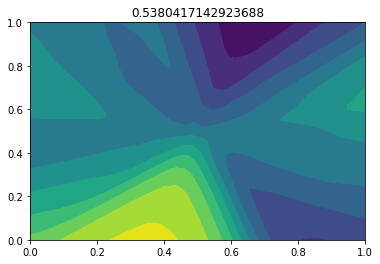

In [16]:
for g in predictor.hist_grid:
    gridpoints = np.linspace(0, 1, g.shape[0])

    plt.title(g.mean())
    plt.contourf(gridpoints, gridpoints, g, 10)
    plt.colorbar
    plt.show()
    display.clear_output(wait=True)
    

In [9]:
# reset the model and dataset
model = MLPClassifier((63,32,))
data = olac.data_generators.roving_balls(steps=1000)
## OFFLINE
# reset the model and dataset
model = MLPClassifier((63,32,))
data = olac.data_generators.roving_balls(steps=1000)

labeller = ThresholdLabeller(threshold=10, prob=0.5)
predictor = OnlinePredictor()
# predictor = OfflinePredictor(batch_size=50)

# pre-train offline model


# create the pipeline
pipeline = olac.pipeline.Pipeline(data, model, predictor, labeller)

# run the pipeline and get the results
train_set_online, eval_set_online = pipeline.run()


Labeller:	Threshold met, 12 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 21 new points available in queue
Predictor:	6 new points available, training...
Labeller:	Labelled 13 new points
Predictor:	13 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Predictor:	7 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, training...
Labeller:	Threshold met, 11 new points 

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, training...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, training...
Labeller:	Threshold met, 11 new points av

In [10]:

df_train_online = olac.utils.queue_point_list_to_df(train_set_online)
df_eval_online = olac.utils.queue_point_list_to_df(eval_set_online)

In [22]:
for g in predictor.hist_grid:
    gridpoints = np.linspace(0, 1, g.shape[0])
    if g.mean()>0:
        plt.title(g.mean())
        plt.contourf(gridpoints, gridpoints, g, 10)
        plt.colorbar
        plt.show()
        display.clear_output(wait=True)
    

NameError: name 'predictor' is not defined

In [11]:
df_eval_offline = df_eval_offline.dropna()
acc_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true']).mean()
print(f'Accuracy: {acc_offline:.2%}')
accs_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true'])
rolling_acc_offline_rb = accs_offline.rolling(20, min_periods=1).mean()

# df_eval_online = df_eval_online.dropna()
# acc_online = (df_eval_online['y_pred'] == df_eval_online['y_true']).mean()
# print(f'Accuracy: {acc_online:.2%}')
# accs_online = (df_eval_online['y_pred'] == df_eval_online['y_true'])
# rolling_acc_online_rb = accs_online.rolling(20, min_periods=1).mean()

# rolling_acc_offline.plot();

Accuracy: 56.87%


In [10]:
## OFFLINE
# reset the model and dataset
model = MLPClassifier((63,32,))
data = olac.data_generators.cluster_generator()

labeller = ThresholdLabeller(threshold=10, prob=0.5)
# predictor = OnlinePredictor()
predictor = OfflinePredictor(batch_size=50)

# pre-train offline model


# create the pipeline
pipeline = olac.pipeline.Pipeline(data, model, predictor, labeller)

# run the pipeline and get the results
train_set_offline, eval_set_offline = pipeline.run()

df_train_offline = queue_point_list_to_df(train_set_offline)
df_eval_offline = queue_point_list_to_df(eval_set_offline)

Labeller:	Threshold met, 21 new points avaible in queue
Labeller:	Labelled 15 new points
Labeller:	Threshold met, 29 new points avaible in queue
Labeller:	Labelled 11 new points
Labeller:	Threshold met, 14 new points avaible in queue
Labeller:	Labelled 7 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeller:	Labelled 5 new points
Labeller:	Threshold met, 11 new points avaible in queue
Labeller:	Labelled 9 new points
Labeller:	Threshold met, 15 new points avaible in queue
Labeller:	Labelled 10 new points
Predictor:	57 new points available, re-training...
Trained model on 57 points
Labeller:	Threshold met, 71 new points avaible in queue
Labeller:	Labelled 36 new points
Labeller:	Threshold met, 31 new points avaible in queue
Labeller:	Labelled 35 new points
Predictor:	71 new points available, re-training...
Trained model on 128 points
Labeller:	Threshold met, 160 new points avaible in queue
Labeller:	Labelled 81 new points
Predictor:	81 new points available, re-train

In [11]:
## ONLINE
# reset the model and dataset
model = MLPClassifier((63,32,))
data = olac.data_generators.cluster_generator(n_points=1000)

labeller = ThresholdLabeller(threshold=10, prob=0.5)
predictor = OnlinePredictor()
# predictor = OfflinePredictor(batch_size=50)

# pre-train offline model


# create the pipeline
pipeline = olac.pipeline.Pipeline(data, model, predictor, labeller)

# run the pipeline and get the results
train_set_online, eval_set_online = pipeline.run()

df_train_online = queue_point_list_to_df(train_set_online)
df_eval_online = queue_point_list_to_df(eval_set_online)

Labeller:	Threshold met, 76 new points avaible in queue
Labeller:	Labelled 107 new points
Labeller:	Threshold met, 75 new points avaible in queue
Predictor:	107 new points available, training...
Labeller:	Labelled 36 new points
Predictor:	36 new points available, training...
Labeller:	Threshold met, 45 new points avaible in queue
Labeller:	Labelled 18 new points
Labeller:	Threshold met, 50 new points avaible in queue
Predictor:	18 new points available, training...
Labeller:	Labelled 25 new points
Predictor:	25 new points available, training...
Labeller:	Threshold met, 15 new points avaible in queue
Labeller:	Labelled 10 new points
Predictor:	10 new points available, training...
Labeller:	Threshold met, 16 new points avaible in queue
Labeller:	Labelled 7 new points
Labeller:	Threshold met, 19 new points avaible in queue
Labeller:	Labelled 10 new points
Predictor:	17 new points available, training...
Labeller:	Threshold met, 16 new points avaible in queue
Labeller:	Labelled 6 new points


In [12]:
df_eval_offline = df_eval_offline.dropna()
acc_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true']).mean()
print(f'Accuracy: {acc_offline:.2%}')
accs_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true'])
rolling_acc_offline = accs_offline.rolling(20, min_periods=1).mean()

df_eval_online = df_eval_online.dropna()
acc_online = (df_eval_online['y_pred'] == df_eval_online['y_true']).mean()
print(f'Accuracy: {acc_online:.2%}')
accs_online = (df_eval_online['y_pred'] == df_eval_online['y_true'])
rolling_acc_online = accs_online.rolling(20, min_periods=1).mean()

# rolling_acc_offline.plot();

Accuracy: 77.55%
Accuracy: 52.63%


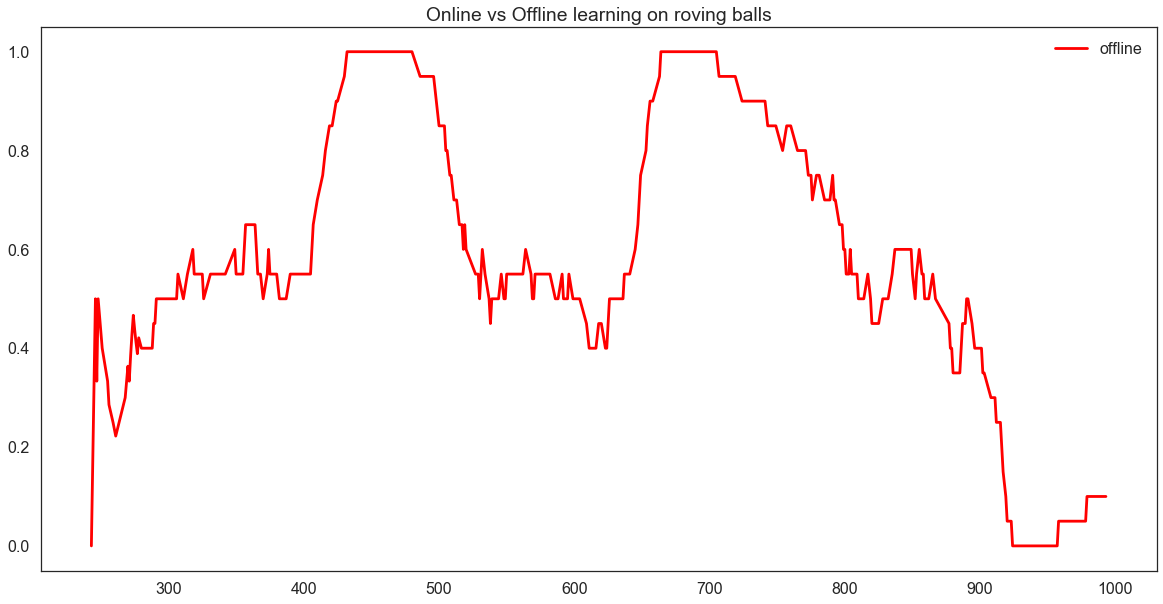

In [12]:
plt.figure(figsize=(20, 10))
plt.title("Online vs Offline learning on roving balls")
plt.plot(rolling_acc_offline_rb, c='r', label='offline')
# plt.plot(rolling_acc_online_rb, c='b', label='online')
plt.legend()

# plt.figure(figsize=(20, 10))
# plt.title("Online vs Offline learning on popping clusters")
# plt.plot(rolling_acc_offline, c='r', label='offline')
# plt.plot(rolling_acc_online, c='b', label='online')
# plt.legend()

# Test pipeline with olac

In [12]:
# # ## ONLINE
# # reset the model and dataset
model = MLPClassifier((63,32,))

labeller = olac.pipeline.ThresholdLabeller(threshold=10, prob=0.5)


predictor_offline = olac.pipeline.OfflinePredictor(batch_size=10)

predictor_online = olac.pipeline.OnlinePredictor()

# create the pipeline
print('--- Online! ---')
data = olac.data_generators.cluster_generator(n_points=1000)
pipelineOn = olac.pipeline.Pipeline(data, model, predictor_online, labeller)
print('--- Offline! ---')
data = olac.data_generators.cluster_generator(n_points=1000)
pipelineOff = olac.pipeline.Pipeline(data, model, predictor_offline, labeller)

# run the pipeline and get the results
train_set_online, eval_set_online = pipelineOn.run()
train_set_offline, eval_set_offline = pipelineOff.run()

df_train_online = olac.utils.queue_point_list_to_df(train_set_online)
df_eval_online = olac.utils.queue_point_list_to_df(eval_set_online)

df_train_offline = olac.utils.queue_point_list_to_df(train_set_offline)
df_eval_offline = olac.utils.queue_point_list_to_df(eval_set_offline)

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Predictor:	13 new points available, re-training...
--- Online! ---
--- Offline! ---
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 2 new points
Trained model on 420 points
Predictor:	2 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, updating...
Labeller:	Threshold met, 12 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Predictor:	7 new points available, updating...
Labeller:	Threshold met

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new point

Trained model on 96 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	11 new points available, re-training...
Trained model on 107 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Trained model on 515 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	14 new points available, re-training...
Trained model on 121 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	11 new points available, re-training...
Trained model on

Trained model on 454 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	10 new points available, re-training...
Trained model on 464 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	13 new points available, re-training...
Trained model on 477 points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points


Accuracy: 60.16%
Accuracy: 86.24%


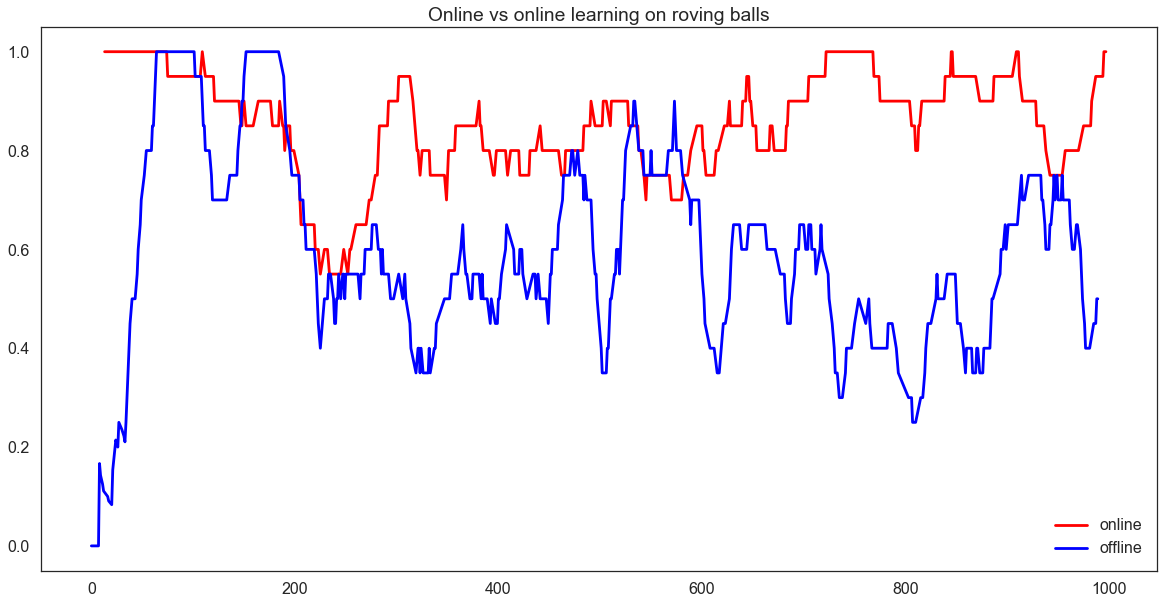

In [13]:
df_eval_offline = df_eval_offline.dropna()
acc_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true']).mean()
print(f'Accuracy: {acc_offline:.2%}')
accs_offline = (df_eval_offline['y_pred'] == df_eval_offline['y_true'])
rolling_acc_offline = accs_offline.rolling(20, min_periods=1).mean()

df_eval_online = df_eval_online.dropna()
acc_online = (df_eval_online['y_pred'] == df_eval_online['y_true']).mean()
print(f'Accuracy: {acc_online:.2%}')
accs_online = (df_eval_online['y_pred'] == df_eval_online['y_true'])
rolling_acc_online = accs_online.rolling(20, min_periods=1).mean()

# rolling_acc_offline.plot();

plt.figure(figsize=(20, 10))
plt.title("Online vs online learning on roving balls")
plt.plot(rolling_acc_online, c='r', label='online')
plt.plot(rolling_acc_offline, c='b', label='offline')
plt.legend()


In [1]:
import pandas as pd
import numpy as np
# import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from olac.pipeline import Pipeline
% matplotlib inline
% load_ext autoreload
% autoreload 2

sns.set_style('white')
sns.set_context('poster')

In [2]:
class MyPredictor(olac.pipeline.OnlinePredictor, olac.pipeline.GridPredictor):
    def __init__(self):
        super().__init__()
        self.grid = self.get_grid()
        self.hist_grid = []
        
    def do_prediction(self, pipeline, x,):
        try:
            self.hist_grid.append(self.grid_predict(pipeline))
        except sklearn.exceptions.NotFittedError:
            # --- still burning in
            l = int(np.sqrt(self.grid.shape[0]))
            self.hist_grid.append(self.grid[:, 0].reshape(l, l))
        
        return super().do_prediction(pipeline, x)

In [22]:
model = MLPClassifier((63,32,), learning_rate='adaptive')
labeller = olac.pipeline.ThresholdLabeller(threshold=10, prob=0.5)
data = olac.data_generators.scaling_generator(olac.data_generators.roving_balls(steps=2000),
                                              -10, 10, -10, 10)
online_grid = MyPredictor()
# data = olac.data_generators.roving_balls(steps=2000)
# online_grid = olac.pipeline.OnlinePredictor()

pipeline = olac.pipeline.Pipeline(data, model, online_grid, labeller)

train_set_grid, eval_set_grid = pipeline.run()

df_train_grid = olac.utils.queue_point_list_to_df(train_set_grid)
df_eval_grid = olac.utils.queue_point_list_to_df(eval_set_grid)


Labeller:	Threshold met, 207 new points available in queue
Labeller:	Labelled 105 new points
Predictor:	105 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Predictor:	7 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, updating...
Labeller:	Threshold met, 11 new poin

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points av

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points av

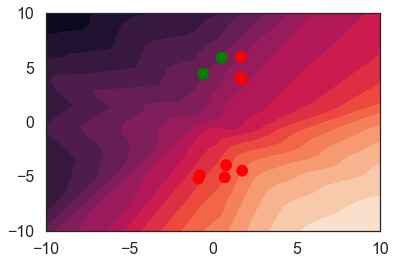

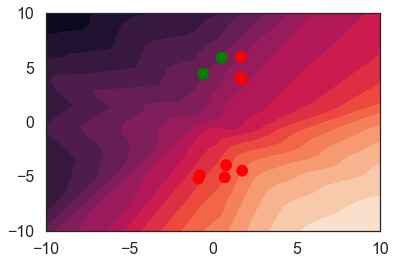

In [25]:
step = 10
X = df_eval_grid[['x0','x1']].values
y = df_eval_grid[['y_pred']].fillna(0).values
grids = np.array(online_grid.hist_grid)
grids = grids[df_eval_grid.index.values.astype(int), :, :]
gridpoints = np.linspace(-10, 10, grids[0].shape[0])
for m in np.arange(0, len(df_eval_grid)-5, step=step):
    plt.contourf(gridpoints, gridpoints, grids[m], 20, origin='lower')
    plt.scatter(*X[m:m+step].T, c=np.array(['r','g'])[y.astype('int')[m:m+step][:,0]])

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [29]:
import olac

In [34]:
model = MLPClassifier((63,32,), learning_rate='adaptive')
labeller = olac.pipeline.ThresholdLabeller(threshold=10, prob=0.5)
data = olac.data_generators.scaling_generator(olac.data_generators.cluster_generator(n_points=2000),
                                              0, 1000, -10, 10)
online_grid = MyPredictor()
# data = olac.data_generators.roving_balls(steps=2000)
# online_grid = olac.pipeline.OnlinePredictor()

pipeline = olac.pipeline.Pipeline(data, model, online_grid, labeller)

train_set_grid, eval_set_grid = pipeline.run()

df_train_grid = olac.utils.queue_point_list_to_df(train_set_grid)
df_eval_grid = olac.utils.queue_point_list_to_df(eval_set_grid)


Labeller:	Threshold met, 31 new points available in queue
Labeller:	Labelled 26 new points
Predictor:	26 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points 

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 7 new points
Predictor:	7 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points av

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 8 new points
Predictor:	8 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 5 new points
Predictor:	5 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 4 new points
Predictor:	4 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 6 new points
Predictor:	6 new points available, updating...
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Predictor:	3 new points available, updating...
Labeller:	Threshold met, 11 new points av

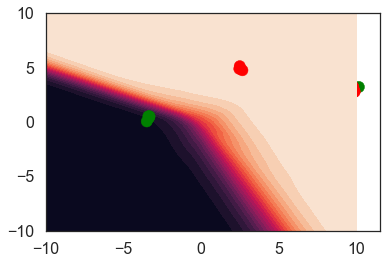

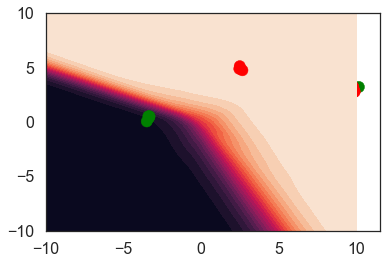

In [36]:
step = 10
X = df_eval_grid[['x0','x1']].values
y = df_eval_grid[['y_pred']].fillna(0).values
grids = np.array(online_grid.hist_grid)
grids = grids[df_eval_grid.index.values.astype(int), :, :]
gridpoints = np.linspace(-10, 10, grids[0].shape[0])
for m in np.arange(0, len(df_eval_grid)-5, step=step):
    plt.contourf(gridpoints, gridpoints, grids[m], 20, origin='lower')
    plt.scatter(*X[m:m+step].T, c=np.array(['r','g'])[y.astype('int')[m:m+step][:,0]])

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [50]:
dataset = pd.DataFrame(list(olac.data_generators.roving_balls(steps=2000)), columns = ['x1','x2','label'])
dataset.to_csv('test.csv')
dataset.to_excel('test.xlsx')

In [82]:
def generator_from_csv(path, data_columns, label_column, n_points=None, **args):
    

    data_columns.append(label_column)
    type_dict = {'xlsx':'excel','csv':'csv'}
    filetype = path.split('.')[-1]
    data = getattr(pd, 'read_' + type_dict[filetype])(path, **args)
    if n_points is None:
        n_points = len(data)
    data = data.loc[:n_points, data_columns]
    
    for point in data.values:
        yield point

In [86]:
def generator_from_df(path, data_columns=None, label_column=None, n_points=None):
    
    try:
        data = data.loc[:n_points, data_columns]
    except TypeError:
        pass
    
    for point in data.values:
        yield point

In [87]:
generator_from_df(dataset)

<generator object generator_from_df at 0x147cd5e60>

In [81]:
for p in generator_from_file('test.xlsx', ['x1','x2'],'label'):
    print(p)

[-0.60193621 -4.95620389  1.        ]
[-0.31265526 -3.14998963  1.        ]
[ 1.14866051 -4.80993944  1.        ]
[-0.50698903 -6.31739968  1.        ]
[-0.98719869 -5.06782183  1.        ]
[-0.49977814  4.40839389  0.        ]
[-1.74867702  5.42508752  0.        ]
[ 1.65250166 -3.54172881  1.        ]
[-0.40810702 -4.46600322  1.        ]
[-2.07175023 -5.43670004  1.        ]
[-0.76174339  6.12833018  0.        ]
[0.43463876 5.21872043 0.        ]
[ 1.11657272 -6.18467508  1.        ]
[0.55166076 5.27037914 0.        ]
[ 2.39970643 -6.7252954   1.        ]
[ 1.81971101 -4.97466674  1.        ]
[-0.67097124  2.58854919  0.        ]
[0.36844416 4.20835506 0.        ]
[ 0.70994217 -5.38090353  1.        ]
[ 1.03614439 -4.88239375  1.        ]
[ 1.25904392 -3.77594606  1.        ]
[1.2594712  6.25194927 0.        ]
[ 0.65565252 -4.73749017  1.        ]
[0.42033795 6.9234214  0.        ]
[-0.01558286  5.44144102  0.        ]
[ 0.30880397 -4.63527483  1.        ]
[0.86905574 5.29340948 0.  

[-0.35242803 -4.64145968  1.        ]
[-2.43795353  5.65939195  0.        ]
[-0.6292063   4.01271939  0.        ]
[-1.41053563  2.83399282  0.        ]
[-2.65978712  5.99609414  0.        ]
[ 2.43230061 -4.06333621  1.        ]
[ 1.03905553 -1.55950966  1.        ]
[-2.91241773  3.51886082  0.        ]
[-1.51273753  4.98725142  0.        ]
[-2.54373688  5.64304596  0.        ]
[-2.07669973  6.18062836  0.        ]
[-2.47080029  3.89966219  0.        ]
[ 0.89466595 -5.50952916  1.        ]
[-2.01725269  5.94592009  0.        ]
[-0.50403311  4.35728938  0.        ]
[-3.88167568  5.74481765  0.        ]
[-1.69646662  5.95135963  0.        ]
[ 1.42624034 -2.66884678  1.        ]
[-1.82554724  4.58279542  0.        ]
[ 2.72583598 -4.68640325  1.        ]
[ 2.19624502 -4.63239878  1.        ]
[-2.75503051  5.27539071  0.        ]
[-2.25101433  4.58677829  0.        ]
[ 1.62035764 -5.89391338  1.        ]
[ 3.73192009 -3.48942446  1.        ]
[-4.24992673  4.91220967  0.        ]
[-2.91946947

[3.18120753 3.93878881 0.        ]
[-0.68090311 -4.43938248  1.        ]
[1.48185944 4.40655026 0.        ]
[-0.17157561 -5.20883489  1.        ]
[-0.68623896 -4.79512976  1.        ]
[3.7726828  3.94535336 0.        ]
[1.02302832 3.80220916 0.        ]
[1.83602542 1.40563539 0.        ]
[-0.41458173 -4.21306729  1.        ]
[2.31458872 4.85014539 0.        ]
[3.24511592 5.01629936 0.        ]
[2.30422145 4.11994768 0.        ]
[0.89000146 5.96096368 0.        ]
[-0.0395383  -3.38643797  1.        ]
[0.56220198 4.62318792 0.        ]
[2.70260663 4.32650062 0.        ]
[-1.66826278 -4.48765211  1.        ]
[0.34402271 4.82095178 0.        ]
[1.73179369 5.72407866 0.        ]
[ 0.31044015 -6.67620445  1.        ]
[-0.86352923 -5.00290364  1.        ]
[0.98930773 6.3653593  0.        ]
[1.95295123 3.62996981 0.        ]
[1.21745052 4.44133337 0.        ]
[1.22020563 3.4809286  0.        ]
[1.36906064 3.7816923  0.        ]
[1.6631929  4.08433405 0.        ]
[-0.81451027 -3.93605688  1.   

In [77]:
['x1', 'x1'].append('t')

In [ ]:
pd.DataFrame()